In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Download data

### Guadalajara hexagons

In [2]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'
city = 'Guadalajara'
type_area = 'urban'

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\' AND \"type\" = \'{type_area}\'"

hex_gdf = aup.gdf_from_query(query)
print(hex_gdf.shape)
hex_gdf.head(2)

(6540, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban


### Estructura urbana - Frente de manzana - Marco Geoestadístico

In [3]:
gdf_tmp = hex_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry("geometry")
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [4]:
query = f"SELECT * FROM urbano.fm_inegi_20_line WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
entorno = aup.gdf_from_query(query, geometry_col='geometry')
print(entorno.shape)
entorno.head(4)

(260916, 68)


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,ESTACIONBICI,ARBOLES,ALUMPUB,TELPUB,PUESTOSEMI,PUESTOAMBU,BANQUETA,GUARNICION,TAMLOC,VIANOESP
0,1403900013891001,14,039,0001,3891,001,08579,00002,1,Barranca,...,8,8,8,8,8,8,8,8,11,0
1,1403900013891001,14,039,0001,3891,001,04254,00001,2,Volcán Villarrica,...,3,1,3,3,3,3,1,1,11,0
2,1403900013891001,14,039,0001,3891,001,04292,00003,3,Volcán Maipo,...,9,9,9,9,9,9,9,9,11,1
3,1403900013891001,14,039,0001,3891,001,04292,00005,5,Volcán Maipo,...,9,9,9,9,9,9,9,9,11,1


In [5]:
entorno.columns

Index(['CVEGEO2', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'CVE_MZA',
       'CVEVIAL_x', 'CVESEG', 'CVEFT_x', 'NOMVIAL_x', 'TIPOVIAL', 'CVEVIAL1',
       'CVESEG1', 'CVEREF1', 'TIPOVR1', 'NOMREF1', 'CVEVIAL2', 'CVESEG2',
       'CVEREF2', 'TIPOVR2', 'NOMREF2', 'CVEVIAL3', 'CVESEG3', 'CVEREF3',
       'TIPOVR3', 'NOMREF3', 'geometry', 'CVEGEO', 'CVEGEOFTE', 'ID_FTE',
       'ID_MZA', 'ENT', 'MUN', 'LOC', 'AGEB', 'MZA', 'CVEFT_y', 'CVEVIAL_y',
       'NOMVIAL_y', 'NOMVIAL_C', 'TIPOVIAL_C', 'ESVIALIDAD', 'CLASEVIA',
       'CLASERASGO', 'OTRORASGO_C', 'RECUCALLE', 'RESTRICPEAT', 'RESTRICAUTO',
       'PASOPEAT', 'DRENAJEP', 'TRANSCOL', 'CICLOVIA', 'CICLOCARRIL',
       'LETRERO', 'RAMPAS', 'SEMAFOROPEAT', 'SEMAFOROAUDI', 'PARADATRANS',
       'ESTACIONBICI', 'ARBOLES', 'ALUMPUB', 'TELPUB', 'PUESTOSEMI',
       'PUESTOAMBU', 'BANQUETA', 'GUARNICION', 'TAMLOC', 'VIANOESP'],
      dtype='object')

## Urban structure analysis

In [6]:
ent_int = entorno.overlay(hex_gdf, how='intersection')
print(ent_int.shape)
ent_int.head(2)

(329714, 73)


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,BANQUETA,GUARNICION,TAMLOC,VIANOESP,hex_id_9,CVEGEO_2,NOMGEO,city,type,geometry
0,1403900013891001,14,039,0001,3891,001,08579,00002,1,Barranca,...,8,8,11,0,89498c94acbffff,14039,Guadalajara,Guadalajara,urban,"LINESTRING (-103.31766 20.74238, -103.31762 20..."
1,1403900013891001,14,039,0001,3891,001,04254,00001,2,Volcán Villarrica,...,1,1,11,0,89498c94acbffff,14039,Guadalajara,Guadalajara,urban,"LINESTRING (-103.31549 20.74362, -103.31553 20..."


In [7]:
ent_int['length'] = ent_int.to_crs("EPSG:32613").length

In [8]:
urban_elements = ['BANQUETA','ALUMPUB','RAMPAS','ARBOLES',
                     'CICLOVIA']

for col in urban_elements:
    ent_tmp = ent_int.loc[(ent_int[col]==1)][['hex_id_9','length']].groupby(['hex_id_9']).sum()
    ent_tot = ent_int.loc[(ent_int[col]==1)|(ent_int[col]==3)][['hex_id_9','length']].groupby(['hex_id_9']).sum().reset_index().rename(columns={'length':                                                                                    'length_'+col})
    ent_tmp = ent_tmp.merge(ent_tot, on='hex_id_9')
    ent_tmp['pct_'+col] = ent_tmp['length'] / ent_tmp['length_'+col]
    ent_tmp = ent_tmp.drop(columns=['length','length_'+col])

    hex_gdf = hex_gdf.merge(ent_tmp, on='hex_id_9', how='left')

In [9]:
hex_gdf = hex_gdf.fillna(0)

<Axes: >

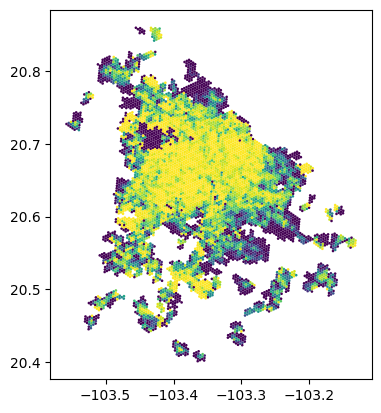

In [10]:
hex_gdf.plot('pct_BANQUETA')

<Axes: >

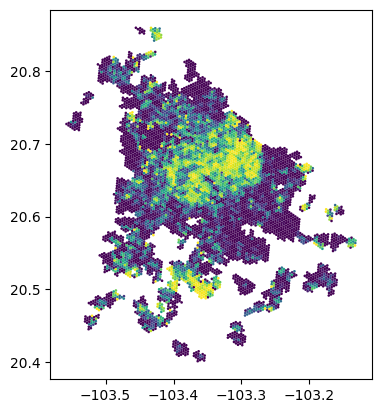

In [11]:
hex_gdf.plot('pct_RAMPAS')

<Axes: >

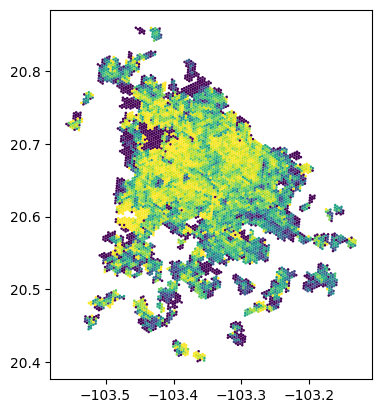

In [12]:
hex_gdf.plot('pct_ARBOLES')

<Axes: >

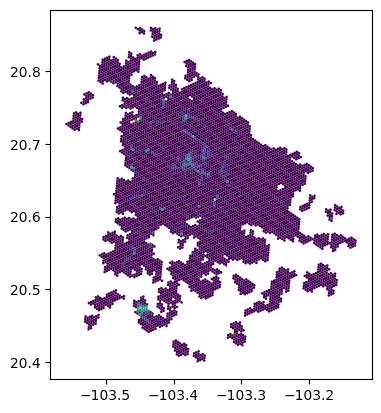

In [13]:
hex_gdf.plot('pct_CICLOVIA')

## Filter data

In [14]:
aoi_gdf = gpd.read_file('../../../data/processed/viviendas_tlajo/AOI_Viviendas_Tlajo.geojson')

In [15]:
if hex_gdf.crs!=aoi_gdf.crs:
    hex_gdf = hex_gdf.to_crs(aoi_gdf.crs)
    print(hex_gdf.crs)

EPSG:32613


In [16]:
hex_clip_id = hex_gdf.clip(aoi_gdf).hex_id_9.unique()
hex_infra_aoi = hex_gdf.loc[hex_gdf.hex_id_9.isin(hex_clip_id)].copy()
print(hex_infra_aoi.shape)
hex_infra_aoi.head(2)

(106, 11)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,pct_BANQUETA,pct_ALUMPUB,pct_RAMPAS,pct_ARBOLES,pct_CICLOVIA
1620,8949aa2ea37ffff,"POLYGON ((668991.147 2270868.529, 669116.373 2...",14097,Tlajomulco de Zúñiga,Guadalajara,urban,0.438522,0.438490,0.299607,0.402497,0.0
1630,8949aa2eac7ffff,"POLYGON ((670209.642 2269635.158, 670334.867 2...",14097,Tlajomulco de Zúñiga,Guadalajara,urban,0.363806,0.641017,0.333490,0.233378,0.0


## Save data

In [17]:
hex_infra_aoi = hex_infra_aoi.rename(columns={'hex_id_9':'hex_id'})

In [18]:
hex_infra_aoi.to_file('../../../data/processed/viviendas_tlajo/AOI_Viviendas_Tlajo.geojson')